# Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Model Architecture

## Patch Embedding

In [2]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size = 224, patch_size = 16, in_chans = 3, embed_dim = 768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size = patch_size,
            stride = patch_size)

    def forward(self, x):
        # x shape: [B, 3, 224, 224]
        x = self.proj(x) # [B, emdbed_dim, H/patch, W/patch]
        x = x.flatten(2) # [B, emdbed_dim, num_patches]
        x = x.transpose(1, 2) # [B, num_patches, embed_dim]
        return x

## Class Token and Positional Embeddings

In [3]:
import torch
import torch.nn as nn

class ViTEmbed(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super().__init__()

        # Learnable [CLS] token (1 per model)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))  # [1, 1, D]

        # Learnable positional embeddings (1 per token, including CLS)
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))  # [1, N+1, D]

    def forward(self, x):
        batch_size = x.shape[0]

        # Expand [CLS] token to match batch size
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # [B, 1, D]

        # Prepend CLS token to patch embeddings
        x = torch.cat((cls_tokens, x), dim=1)  # [B, N+1, D]

        # Add positional embeddings
        x = x + self.pos_embed  # [B, N+1, D]

        return x

## Multi-Head Self-Attention

In [4]:
class MyMultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Learnable projections for Q, K, V
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)

        # Final output projection
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, T, C = x.shape  # [batch, seq_len, embed_dim]

        # Project input into Q, K, V
        Q = self.q_proj(x)
        K = self.k_proj(x)
        V = self.v_proj(x)

        # Reshape into heads: [B, num_heads, T, head_dim]
        def split_heads(tensor):
            return tensor.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        Q = split_heads(Q)
        K = split_heads(K)
        V = split_heads(V)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1))  # [B, heads, T, T]
        scores /= self.head_dim ** 0.5
        attn = torch.softmax(scores, dim=-1)

        # Apply attention to values
        out = torch.matmul(attn, V)  # [B, heads, T, head_dim]

        # Recombine heads
        out = out.transpose(1, 2).contiguous().view(B, T, C)

        # Final linear projection
        return self.out_proj(out)

## Transformer Encoder

In [5]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim)
        )

    def forward(self, x):
        # Self-attention with residual connection
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]

        # MLP with residual connection
        x = x + self.mlp(self.norm2(x))
        return x

## Putting It All Together

In [6]:
class SimpleViT(nn.Module):
    def __init__(
        self, img_size=224, patch_size=16, in_chans=3,
        embed_dim=768, depth=12, num_heads=12, num_classes=1000
    ):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = (img_size // patch_size) ** 2
        self.vit_embed = ViTEmbed(num_patches, embed_dim)

        # Stack transformer blocks
        self.blocks = nn.Sequential(*[
            TransformerBlock(embed_dim, num_heads) for _ in range(depth)
        ])

        # Final normalization before classification
        self.norm = nn.LayerNorm(embed_dim)

        # Linear classification head (using the CLS token)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):  # [batch_size, channels, height, width]
        x = self.patch_embed(x)         # -> [B, N, D]
        x = self.vit_embed(x)           # add CLS token + pos embed
        x = self.blocks(x)              # transformer layers
        x = self.norm(x)                # normalize CLS token
        return self.head(x[:, 0])       # classification using CLS token

# Training

In [7]:
def evaluate(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = outputs.argmax(dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [8]:
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=80, shuffle=True)
testloader = DataLoader(testset, batch_size=80)

100%|██████████| 170M/170M [00:03<00:00, 43.8MB/s]


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Refactored SimpleViT config for CIFAR-10
model = SimpleViT(
    img_size=32,         # CIFAR-10 images are 32x32
    patch_size=4,        # 4x4 patches → 64 tokens
    in_chans=3,
    embed_dim=192,       # Smaller embedding size
    depth=6,             # Fewer transformer blocks
    num_heads=3,         # Divides evenly into 192
    num_classes=10       # For CIFAR-10
).to(device)

optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

## Training Loop

In [10]:
def train(model, trainloader, testloader, optimizer, criterion, device, epochs=5):
    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)

        # Evaluate on test set after each epoch
        test_acc = evaluate(model, testloader, device)
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Test Accuracy: {test_acc:.4f}")

    return train_losses, test_accuracies

In [11]:
train_losses, test_accuracies = train(model, trainloader, testloader, optimizer, criterion, device, epochs=30)

Epoch 1/30: 100%|██████████| 625/625 [00:32<00:00, 18.95it/s]


Epoch 1/30 | Loss: 1.7814 | Test Accuracy: 0.4424


Epoch 2/30: 100%|██████████| 625/625 [00:32<00:00, 19.12it/s]


Epoch 2/30 | Loss: 1.4317 | Test Accuracy: 0.5128


Epoch 3/30: 100%|██████████| 625/625 [00:32<00:00, 19.10it/s]


Epoch 3/30 | Loss: 1.2916 | Test Accuracy: 0.5365


Epoch 4/30: 100%|██████████| 625/625 [00:33<00:00, 18.89it/s]


Epoch 4/30 | Loss: 1.2132 | Test Accuracy: 0.5490


Epoch 5/30: 100%|██████████| 625/625 [00:33<00:00, 18.79it/s]


Epoch 5/30 | Loss: 1.1525 | Test Accuracy: 0.5522


Epoch 6/30: 100%|██████████| 625/625 [00:33<00:00, 18.82it/s]


Epoch 6/30 | Loss: 1.1044 | Test Accuracy: 0.5888


Epoch 7/30: 100%|██████████| 625/625 [00:33<00:00, 18.75it/s]


Epoch 7/30 | Loss: 1.0584 | Test Accuracy: 0.5878


Epoch 8/30: 100%|██████████| 625/625 [00:33<00:00, 18.77it/s]


Epoch 8/30 | Loss: 1.0149 | Test Accuracy: 0.5798


Epoch 9/30: 100%|██████████| 625/625 [00:33<00:00, 18.73it/s]


Epoch 9/30 | Loss: 0.9708 | Test Accuracy: 0.5991


Epoch 10/30: 100%|██████████| 625/625 [00:33<00:00, 18.76it/s]


Epoch 10/30 | Loss: 0.9240 | Test Accuracy: 0.5990


Epoch 11/30: 100%|██████████| 625/625 [00:33<00:00, 18.84it/s]


Epoch 11/30 | Loss: 0.8728 | Test Accuracy: 0.6083


Epoch 12/30: 100%|██████████| 625/625 [00:33<00:00, 18.88it/s]


Epoch 12/30 | Loss: 0.8223 | Test Accuracy: 0.6050


Epoch 13/30: 100%|██████████| 625/625 [00:33<00:00, 18.83it/s]


Epoch 13/30 | Loss: 0.7666 | Test Accuracy: 0.6088


Epoch 14/30: 100%|██████████| 625/625 [00:33<00:00, 18.81it/s]


Epoch 14/30 | Loss: 0.7035 | Test Accuracy: 0.6194


Epoch 15/30: 100%|██████████| 625/625 [00:33<00:00, 18.84it/s]


Epoch 15/30 | Loss: 0.6371 | Test Accuracy: 0.6012


Epoch 16/30: 100%|██████████| 625/625 [00:33<00:00, 18.83it/s]


Epoch 16/30 | Loss: 0.5691 | Test Accuracy: 0.6057


Epoch 17/30: 100%|██████████| 625/625 [00:33<00:00, 18.84it/s]


Epoch 17/30 | Loss: 0.4982 | Test Accuracy: 0.6112


Epoch 18/30: 100%|██████████| 625/625 [00:33<00:00, 18.81it/s]


Epoch 18/30 | Loss: 0.4283 | Test Accuracy: 0.6076


Epoch 19/30: 100%|██████████| 625/625 [00:33<00:00, 18.84it/s]


Epoch 19/30 | Loss: 0.3733 | Test Accuracy: 0.6003


Epoch 20/30: 100%|██████████| 625/625 [00:33<00:00, 18.84it/s]


Epoch 20/30 | Loss: 0.3169 | Test Accuracy: 0.5950


Epoch 21/30: 100%|██████████| 625/625 [00:33<00:00, 18.85it/s]


Epoch 21/30 | Loss: 0.2686 | Test Accuracy: 0.5991


Epoch 22/30: 100%|██████████| 625/625 [00:33<00:00, 18.84it/s]


Epoch 22/30 | Loss: 0.2352 | Test Accuracy: 0.5976


Epoch 23/30: 100%|██████████| 625/625 [00:33<00:00, 18.88it/s]


Epoch 23/30 | Loss: 0.2032 | Test Accuracy: 0.5831


Epoch 24/30: 100%|██████████| 625/625 [00:33<00:00, 18.87it/s]


Epoch 24/30 | Loss: 0.1902 | Test Accuracy: 0.5967


Epoch 25/30: 100%|██████████| 625/625 [00:33<00:00, 18.84it/s]


Epoch 25/30 | Loss: 0.1629 | Test Accuracy: 0.5896


Epoch 26/30: 100%|██████████| 625/625 [00:33<00:00, 18.85it/s]


Epoch 26/30 | Loss: 0.1556 | Test Accuracy: 0.5993


Epoch 27/30: 100%|██████████| 625/625 [00:33<00:00, 18.88it/s]


Epoch 27/30 | Loss: 0.1440 | Test Accuracy: 0.5951


Epoch 28/30: 100%|██████████| 625/625 [00:33<00:00, 18.83it/s]


Epoch 28/30 | Loss: 0.1412 | Test Accuracy: 0.5901


Epoch 29/30: 100%|██████████| 625/625 [00:33<00:00, 18.88it/s]


Epoch 29/30 | Loss: 0.1285 | Test Accuracy: 0.5947


Epoch 30/30: 100%|██████████| 625/625 [00:33<00:00, 18.85it/s]


Epoch 30/30 | Loss: 0.1259 | Test Accuracy: 0.5987


## Plots

In [12]:
def plot_metrics(train_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies, marker='o', color='green')
    plt.title("Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.tight_layout()
    plt.show()

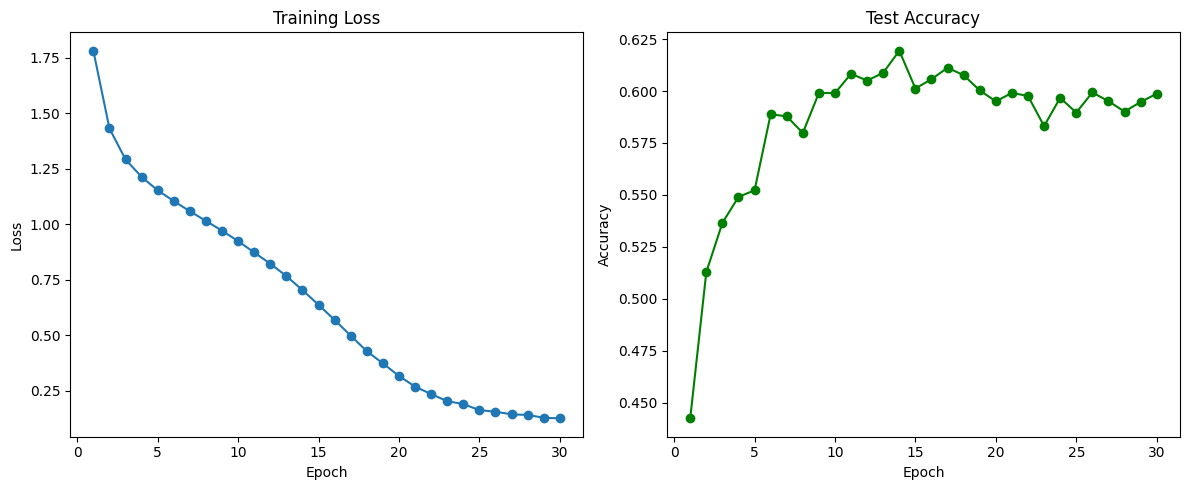

In [13]:
plot_metrics(train_losses, test_accuracies)

In [14]:
def class_accuracy(model, dataloader, classes, device):
    correct = [0] * len(classes)
    total = [0] * len(classes)

    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            for label, pred in zip(labels, preds):
                total[label] += 1
                correct[label] += int(pred == label)

    accs = [100 * c / t if t else 0 for c, t in zip(correct, total)]

    plt.figure(figsize=(10, 4))
    plt.bar(classes, accs)
    plt.ylabel("Accuracy (%)")
    plt.xticks(rotation=45)
    plt.title("Accuracy per Class")
    plt.show()


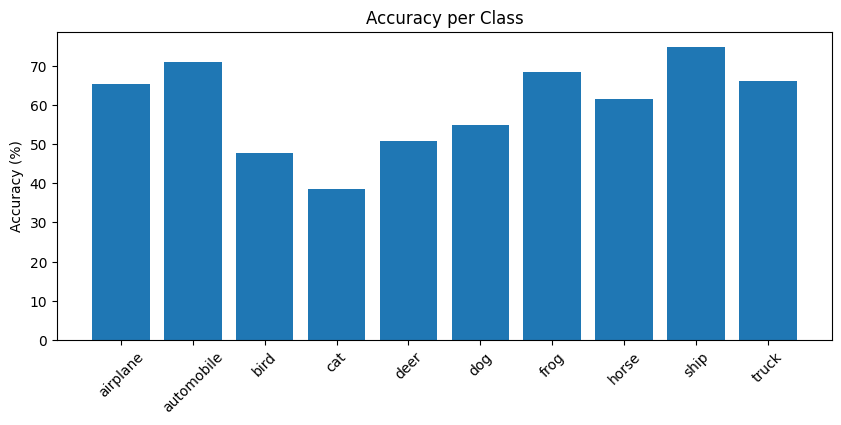

In [15]:
classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

class_accuracy(model, testloader, classes, device)

In [16]:
def show_predictions(model, dataloader, classes, device, n=6):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images[:n].to(device), labels[:n].to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = outputs.argmax(dim=1)

    images = images.cpu()
    fig, axs = plt.subplots(1, n, figsize=(15, 3))
    for i in range(n):
        axs[i].imshow(images[i].permute(1, 2, 0))
        axs[i].set_title(f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}")
        axs[i].axis('off')
    plt.show()

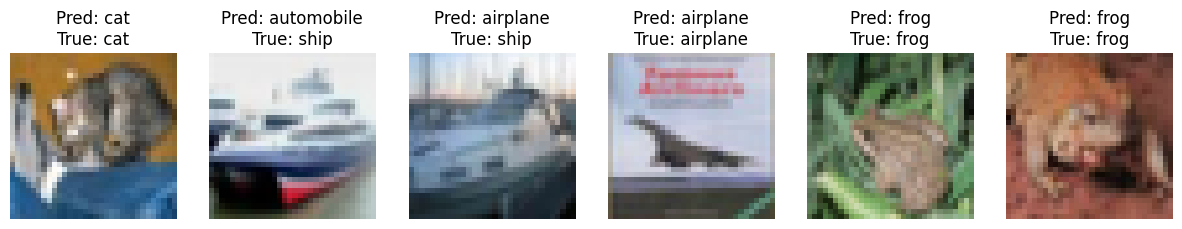

In [17]:
show_predictions(model, testloader, classes, device)